# Cancelación de reservas de una empresa hotelera

La cancelación de reservas es un inconveniente para el gremio hotelero. Para sopesar las pérdidas es común la práctica de la sobre reserva, en la que una habitación se agenda a dos clientes contando con que uno de ellos cancele. Esto puede causar molestias a los visitantes del hotel si no se hace con cuidado, por lo que una solución basada en ML podría aumentar la cantidad de habitaciones ocupadas en épocas de muy alta demanda con el mínimo de inconvenientes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import randint
import random
mpl.style.use('seaborn')
sns.set(rc={"figure.figsize":(35, 20)})

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from lightgbm import LGBMClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

pd.set_option("max_columns", None)
%matplotlib inline

In [2]:
df = pd.read_csv(r"C:\Users\pablo\Documents\Data_Science\Data_sets\hotel_booking.csv")

In [3]:
df.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734


## EDA

#### El problema

Este data set muestra el historial de recervas de dos hoteles de Portugal, un hotel en la ciudad y otro a las afueras. La columna is_canceled muestra si la recerva se canceló.

In [4]:
df.shape

(119390, 36)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

En este dataset se encuentran datos personales de las personas que reservaron tales como nombre, teléfono, email y los últimos numeros de su tarjeta de crédito. Teniendo ya columnas que nos cuentan el rango de edad de las personas, podemos borrar la información personal.

### Agrupación de los datos

#### Variables categóricas

##### Tipo de hotel

In [8]:
df.hotel.unique()

array(['Resort Hotel', 'City Hotel'], dtype=object)

Hay dos tipos de hoteles, puede convertirse en 1 y 0

<AxesSubplot:xlabel='hotel', ylabel='Count'>

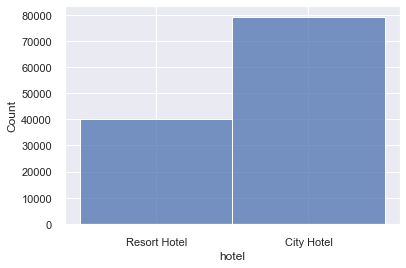

In [24]:
sns.histplot(data=df, x= "hotel", kde=False, bins=5)

In [10]:
df.groupby("hotel")["is_canceled"].mean()*100

hotel
City Hotel      41.726963
Resort Hotel    27.763355
Name: is_canceled, dtype: float64

City hotel tiene un 42% de las entradas

##### Target

In [11]:
df.is_canceled.unique()

array([0, 1], dtype=int64)

Este es el target, esto nos permite desplegar modelos supervisados de clasificación

<AxesSubplot:xlabel='is_canceled', ylabel='Count'>

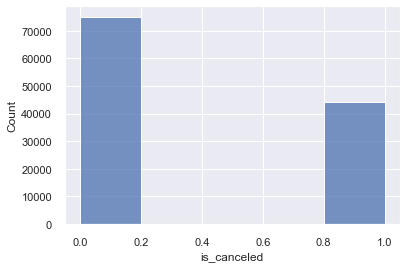

In [12]:
sns.histplot(data=df, x= "is_canceled", kde=False, bins=5)

In [13]:
df.groupby("is_canceled").describe()

lead_time                                                          \
                count        mean         std  min   25%    50%    75%    max   
is_canceled                                                                     
0             75166.0   79.984687   91.109888  0.0   9.0   45.0  124.0  737.0   
1             44224.0  144.848815  118.624829  0.0  48.0  113.0  214.0  629.0   

            arrival_date_year                                                 \
                        count         mean       std     min     25%     50%   
is_canceled                                                                    
0                     75166.0  2016.147514  0.703124  2015.0  2016.0  2016.0   
1                     44224.0  2016.171920  0.714557  2015.0  2016.0  2016.0   

                            arrival_date_week_number                        \
                75%     max                    count       mean        std   
is_canceled                                                                  
0            2017.0  2017.0                  75166.0  27.080143  13.902478   
1            2017.0  2017.0                  44224.0  27.309696  13.083155   

                                         arrival_date_day_of_month             \
             min   25%   50%   75%   max                     count       mean   
is_canceled                                                                     
0            1.0  16.0  28.0  38.0  53.0                   75166.0  15.839529   
1            1.0  17.0  27.0  38.0  53.0                   44224.0  15.728066   

                                                  stays_in_weekend_nights  \
                  std  min  25%   50%   75%   max                   count   
is_canceled                                                                 
0            8.776422  1.0  8.0  16.0  23.0  31.0                 75166.0   
1            8.787969  1.0  8.0  16.0  23.0  31.0                 44224.0   

                                                           \
                 mean       std  min  25%  50%  75%   max   
is_canceled                                                 
0            0.928971  0.993371  0.0  0.0  1.0  2.0  19.0   
1            0.925267  1.007468  0.0  0.0  1.0  2.0  16.0   

            stays_in_week_nights                                          \
                           count      mean       std  min  25%  50%  75%   
is_canceled                                                                
0                        75166.0  2.464053  1.924803  0.0  1.0  2.0  3.0   
1                        44224.0  2.561912  1.878296  0.0  1.0  2.0  3.0   

                    adults                                                \
              max    count      mean       std  min  25%  50%  75%   max   
is_canceled                                                                
0            50.0  75166.0  1.829737  0.510451  0.0  2.0  2.0  2.0   4.0   
1            40.0  44224.0  1.901728  0.678038  0.0  2.0  2.0  2.0  55.0   

            children                                                 babies  \
               count      mean       std  min  25%  50%  75%   max    count   
is_canceled                                                                   
0            75166.0  0.102347  0.390836  0.0  0.0  0.0  0.0   3.0  75166.0   
1            44220.0  0.106513  0.411352  0.0  0.0  0.0  0.0  10.0  44224.0   

                                                          is_repeated_guest  \
                 mean       std  min  25%  50%  75%   max             count   
is_canceled                                                                   
0            0.010377  0.113007  0.0  0.0  0.0  0.0  10.0           75166.0   
1            0.003821  0.062429  0.0  0.0  0.0  0.0   2.0           44224.0   

                                                          \
                 mean       std  min  25%  50%  75%  max   
is_canceled                               

Las reservas no canceladas son mayoría.

#### Temporalidad

In [15]:
df.arrival_date_year.unique()

array([2015, 2016, 2017], dtype=int64)

<AxesSubplot:xlabel='arrival_date_year', ylabel='is_canceled'>

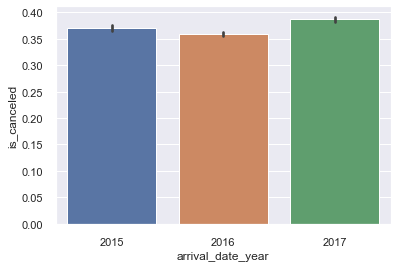

In [16]:
sns.barplot(data=df, x= "arrival_date_year", y="is_canceled")

In [17]:
df.arrival_date_month.unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

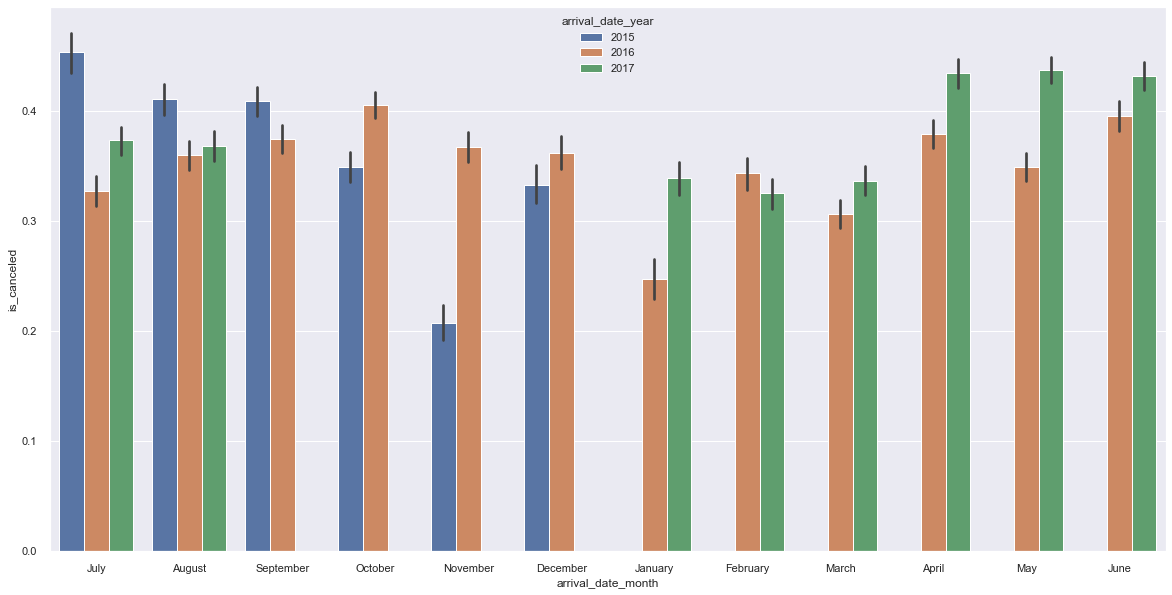

In [81]:
plt.figure(figsize=[20,10])
arrival_date_graph = sns.barplot(data=df, x= "arrival_date_month", y="is_canceled", hue="arrival_date_year")

<AxesSubplot:xlabel='arrival_date_month', ylabel='is_canceled'>

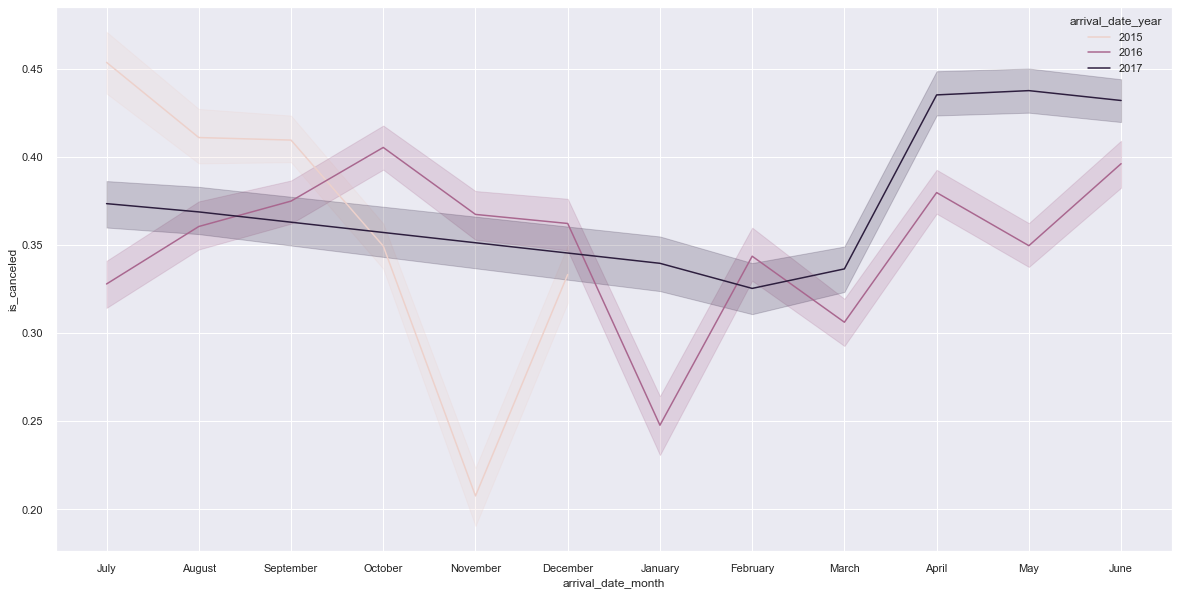

In [14]:
plt.figure(figsize=[20,10])
sns.lineplot(data=df, x= "arrival_date_month", y="is_canceled", hue="arrival_date_year")

Los datos están tomados desde julio del 2015 hasta agosto del 2017. Temporadas como el verano parecen tener un mayor 

#### Tipo de comida

In [21]:
df.meal.unique()

array(['BB', 'FB', 'HB', 'SC', 'Undefined'], dtype=object)

No parece ser una variable muy relevante, vemos su correlación con el target.

In [22]:
df[["meal", "is_canceled"]].groupby("meal", 
    as_index=False).mean().sort_values(by="is_canceled", ascending=False)

,meal,is_canceled
1,FB,0.598997
0,BB,0.373849
3,SC,0.372394
2,HB,0.344603
4,Undefined,0.244654


Solo uno de los valores tiene una correlación >0.5

<AxesSubplot:xlabel='meal'>

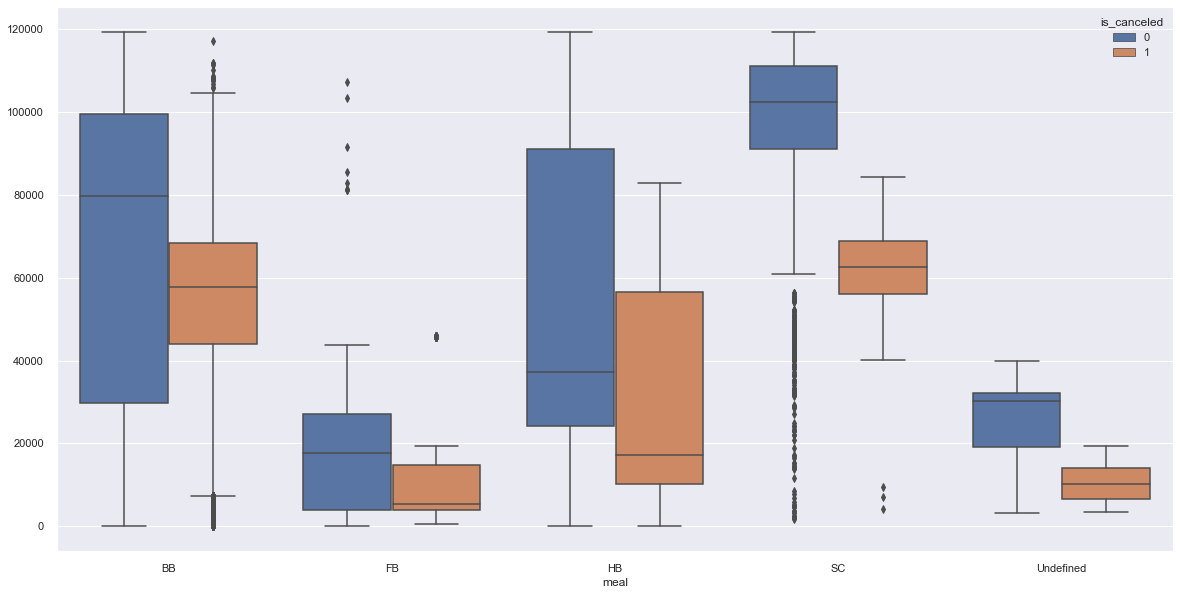

In [25]:
plt.figure(figsize=[20,10])
sns.boxplot(data=df, x= "meal", y=df["meal"].index, hue="is_canceled")

Es una columna con muchos datos anómalos. 

In [24]:
df.groupby("meal").mean()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
meal,,,,,,,,,,,,,,,,,,,,
BB,0.373849,101.797010,2016.143961,27.164413,15.839097,0.891485,2.435955,1.844654,0.111954,0.007475,0.037623,0.078226,0.171087,0.208721,87.411964,187.552977,2.338122,99.407041,0.066472,0.565258
FB,0.598997,116.666667,2015.656642,30.713033,15.523810,1.140351,2.855890,1.958647,0.097744,0.030075,0.011278,1.567669,0.026316,0.302005,114.411326,167.823529,0.041353,109.040476,0.068922,0.233083
HB,0.344603,143.338865,2016.046118,28.570836,15.675309,1.210676,3.124525,1.932932,0.120791,0.012584,0.012860,0.120307,0.022056,0.319782,126.154098,137.307018,3.689345,120.307041,0.068312,0.531840
SC,0.372394,70.678779,2016.447512,25.408920,15.522723,0.815775,2.115962,1.850235,0.017559,0.003474,0.010329,0.010610,0.021033,0.172394,17.057674,242.101695,0.032394,98.295869,0.022629,0.746667
Undefined,0.244654,87.341317,2016.207870,23.412318,16.790419,1.150556,3.117194,1.823781,0.048760,0.013687,0.027374,0.065013,0.009410,0.368691,225.139591,441.824561,6.461078,91.948306,0.037639,0.176219


##### Países

In [25]:
df.country.unique()

array(['PRT', 'GBR', 'USA', 'ESP', 'IRL', 'FRA', nan, 'ROU', 'NOR', 'OMN',
       'ARG', 'POL', 'DEU', 'BEL', 'CHE', 'CN', 'GRC', 'ITA', 'NLD',
       'DNK', 'RUS', 'SWE', 'AUS', 'EST', 'CZE', 'BRA', 'FIN', 'MOZ',
       'BWA', 'LUX', 'SVN', 'ALB', 'IND', 'CHN', 'MEX', 'MAR', 'UKR',
       'SMR', 'LVA', 'PRI', 'SRB', 'CHL', 'AUT', 'BLR', 'LTU', 'TUR',
       'ZAF', 'AGO', 'ISR', 'CYM', 'ZMB', 'CPV', 'ZWE', 'DZA', 'KOR',
       'CRI', 'HUN', 'ARE', 'TUN', 'JAM', 'HRV', 'HKG', 'IRN', 'GEO',
       'AND', 'GIB', 'URY', 'JEY', 'CAF', 'CYP', 'COL', 'GGY', 'KWT',
       'NGA', 'MDV', 'VEN', 'SVK', 'FJI', 'KAZ', 'PAK', 'IDN', 'LBN',
       'PHL', 'SEN', 'SYC', 'AZE', 'BHR', 'NZL', 'THA', 'DOM', 'MKD',
       'MYS', 'ARM', 'JPN', 'LKA', 'CUB', 'CMR', 'BIH', 'MUS', 'COM',
       'SUR', 'UGA', 'BGR', 'CIV', 'JOR', 'SYR', 'SGP', 'BDI', 'SAU',
       'VNM', 'PLW', 'QAT', 'EGY', 'PER', 'MLT', 'MWI', 'ECU', 'MDG',
       'ISL', 'UZB', 'NPL', 'BHS', 'MAC', 'TGO', 'TWN', 'DJI', 'STP',
       'KNA', 'E

In [26]:
df.country.nunique()

177

In [27]:
df.country.value_counts().reset_index()

,index,country
0,PRT,48590
1,GBR,12129
2,FRA,10415
3,ESP,8568
4,DEU,7287
...,...,...
172,DJI,1
173,BWA,1
174,HND,1
175,VGB,1


Este dataset es de un grupo hotelero de Portugal, tiene sentido que haya tantos visitantes de este país y naciones aledañas.

#### Segmento de mercado

In [28]:
df.market_segment.unique()

array(['Direct', 'Corporate', 'Online TA', 'Offline TA/TO',
       'Complementary', 'Groups', 'Undefined', 'Aviation'], dtype=object)

<AxesSubplot:ylabel='market_segment'>

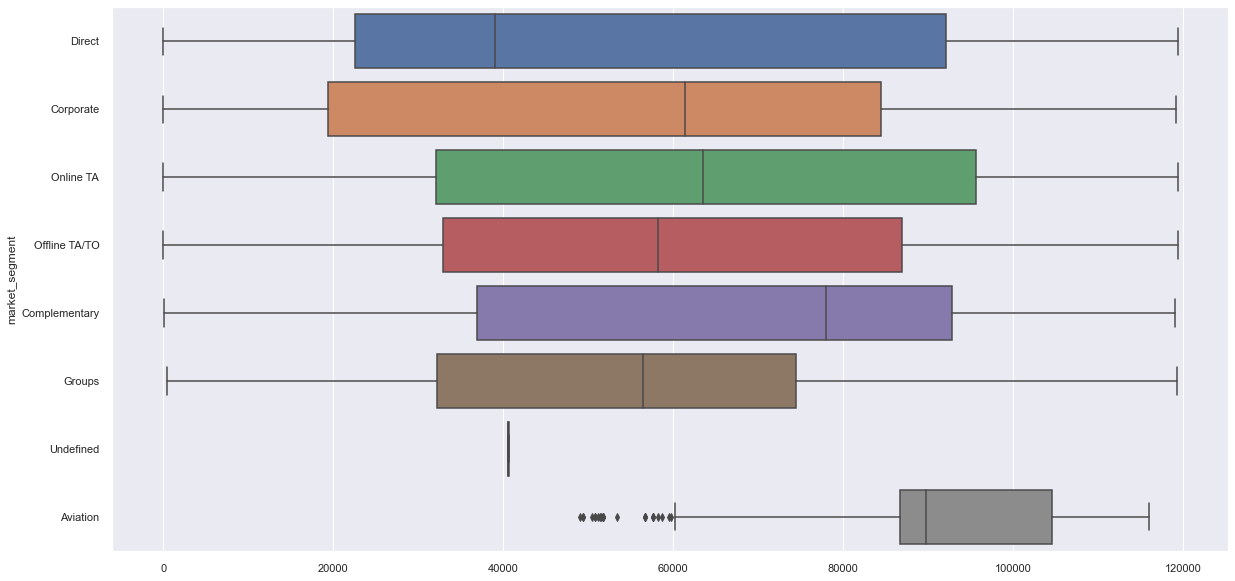

In [26]:
plt.figure(figsize=[20,10])
sns.boxplot(data=df, x=df["market_segment"].index, y=df["market_segment"])

In [30]:
df.distribution_channel.unique()

array(['Direct', 'Corporate', 'TA/TO', 'Undefined', 'GDS'], dtype=object)

<AxesSubplot:ylabel='distribution_channel'>

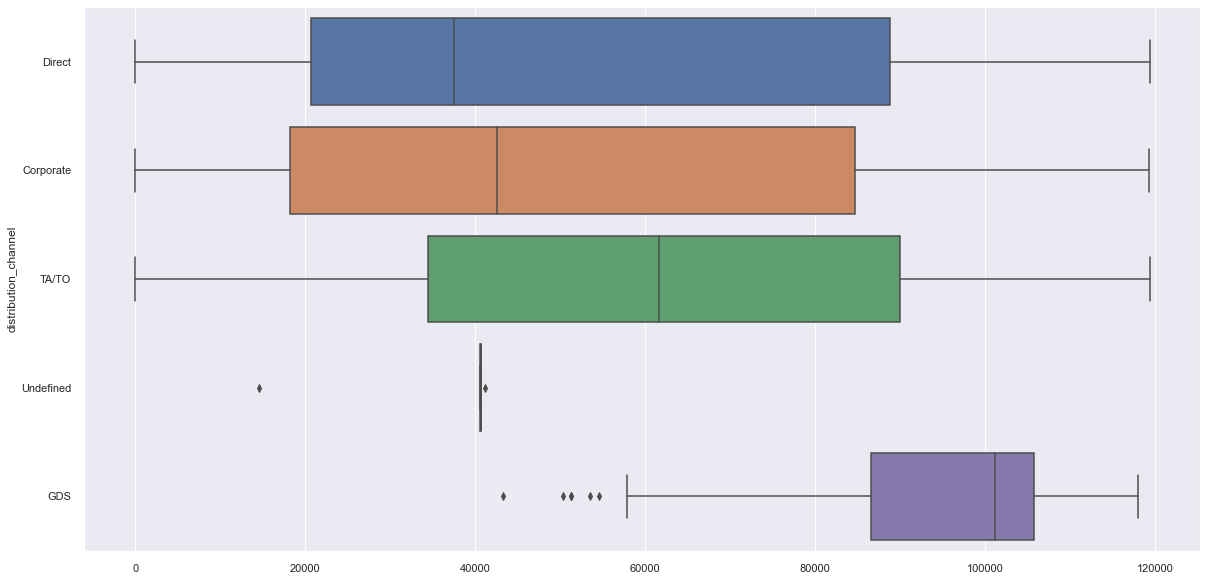

In [27]:
plt.figure(figsize=[20,10])
sns.boxplot(data=df, x=df["distribution_channel"].index, y=df["distribution_channel"])

Aviación representa un segmento de mercado importante.

In [32]:
df.is_repeated_guest.unique()

array([0, 1], dtype=int64)

<AxesSubplot:xlabel='arrival_date_month', ylabel='is_canceled'>

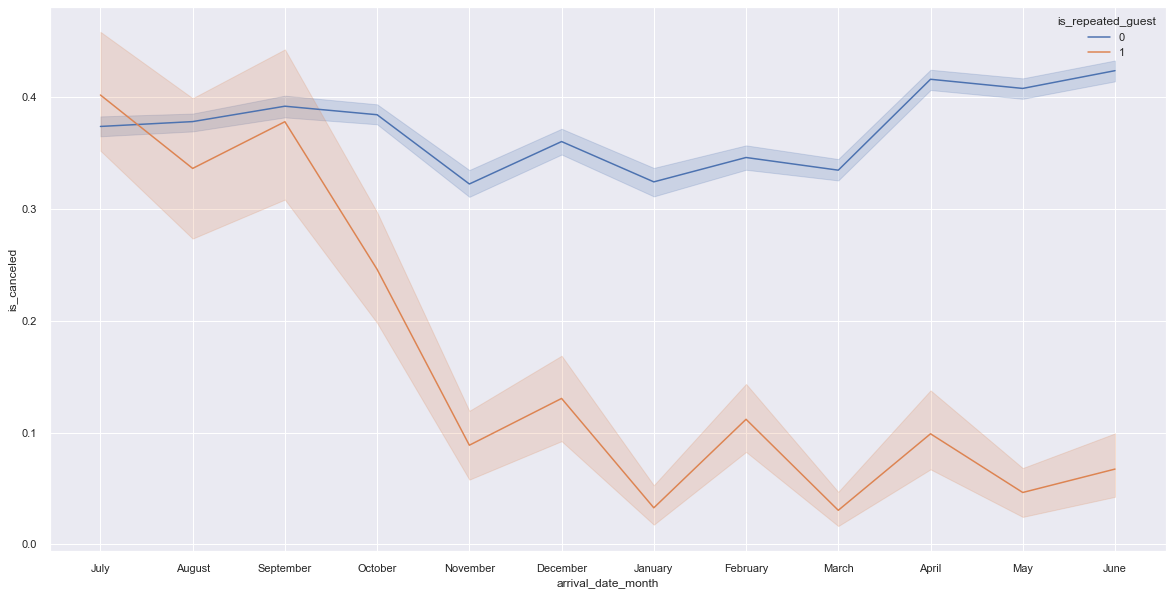

In [30]:
plt.figure(figsize=[20,10])
sns.lineplot(data=df, hue='is_repeated_guest', x="arrival_date_month", y="is_canceled")

In [34]:
df[['is_repeated_guest', "is_canceled"]].groupby('is_repeated_guest', 
    as_index=False).mean().sort_values(by="is_canceled", ascending=False)

,is_repeated_guest,is_canceled
0,0,0.377851
1,1,0.144882


Los clientes que ya se han quedado en el hotel tienden a cancelar menos, salvo en verano.

#### Asignación de habitaciones

In [35]:
df.reserved_room_type.unique()

array(['C', 'A', 'D', 'E', 'G', 'F', 'H', 'L', 'P', 'B'], dtype=object)

In [36]:
df.assigned_room_type.unique()

array(['C', 'A', 'D', 'E', 'G', 'F', 'I', 'B', 'H', 'P', 'L', 'K'],
      dtype=object)

La habitación tipo 'I' y 'K' no estan en la columna de reservadas 

#### Cancelaciones previas

In [37]:
df.deposit_type.unique()

array(['No Deposit', 'Refundable', 'Non Refund'], dtype=object)

<AxesSubplot:xlabel='deposit_type', ylabel='is_canceled'>

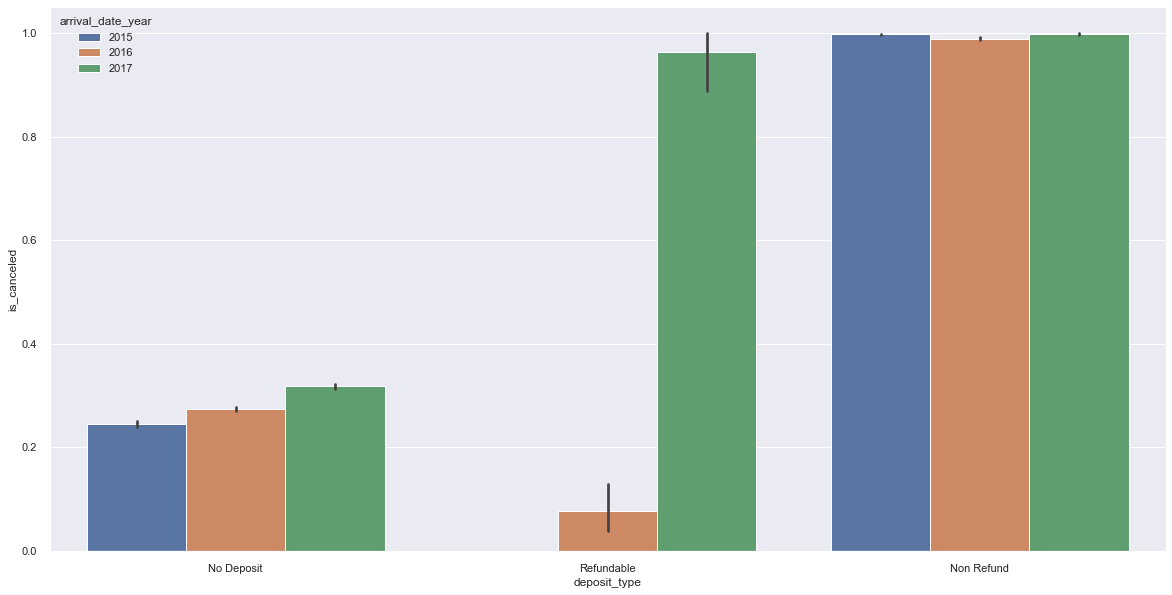

In [43]:
plt.figure(figsize=[20,10])
sns.barplot(data=df, x='deposit_type', hue="arrival_date_year", y="is_canceled")

#### Agentes o compañías de viajes

In [41]:
df.agent.unique()

array([ nan, 304., 240., 303.,  15., 241.,   8., 250., 115.,   5., 175.,
       134., 156., 243., 242.,   3., 105.,  40., 147., 306., 184.,  96.,
         2., 127.,  95., 146.,   9., 177.,   6., 143., 244., 149., 167.,
       300., 171., 305.,  67., 196., 152., 142., 261., 104.,  36.,  26.,
        29., 258., 110.,  71., 181.,  88., 251., 275.,  69., 248., 208.,
       256., 314., 126., 281., 273., 253., 185., 330., 334., 328., 326.,
       321., 324., 313.,  38., 155.,  68., 335., 308., 332.,  94., 348.,
       310., 339., 375.,  66., 327., 387., 298.,  91., 245., 385., 257.,
       393., 168., 405., 249., 315.,  75., 128., 307.,  11., 436.,   1.,
       201., 183., 223., 368., 336., 291., 464., 411., 481.,  10., 154.,
       468., 410., 390., 440., 495., 492., 493., 434.,  57., 531., 420.,
       483., 526., 472., 429.,  16., 446.,  34.,  78., 139., 252., 270.,
        47., 114., 301., 193., 182., 135., 350., 195., 352., 355., 159.,
       363., 384., 360., 331., 367.,  64., 406., 16

Estos son IDs

In [42]:
df.company.unique()

array([ nan, 110., 113., 270., 178., 240., 154., 144., 307., 268.,  59.,
       204., 312., 318.,  94., 174., 274., 195., 223., 317., 281., 118.,
        53., 286.,  12.,  47., 324., 342., 373., 371., 383.,  86.,  82.,
       218.,  88.,  31., 397., 392., 405., 331., 367.,  20.,  83., 416.,
        51., 395., 102.,  34.,  84., 360., 394., 457., 382., 461., 478.,
       386., 112., 486., 421.,   9., 308., 135., 224., 504., 269., 356.,
       498., 390., 513., 203., 263., 477., 521., 169., 515., 445., 337.,
       251., 428., 292., 388., 130., 250., 355., 254., 543., 531., 528.,
        62., 120.,  42.,  81., 116., 530., 103.,  39.,  16.,  92.,  61.,
       501., 165., 291., 290.,  43., 325., 192., 108., 200., 465., 287.,
       297., 490., 482., 207., 282., 437., 225., 329., 272.,  28.,  77.,
       338.,  72., 246., 319., 146., 159., 380., 323., 511., 407., 278.,
        80., 403., 399.,  14., 137., 343., 346., 347., 349., 289., 351.,
       353.,  54.,  99., 358., 361., 362., 366., 37

#### tipo de cliente

In [43]:
df.customer_type.unique()

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

In [44]:
df.reservation_status.unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

In [45]:
df[["reservation_status", "is_canceled"]].groupby("reservation_status", as_index=False).mean().sort_values(by="is_canceled", ascending=False)

,reservation_status,is_canceled
0,Canceled,1.0
2,No-Show,1.0
1,Check-Out,0.0


Esta variable puede estar muy correlacionada con el target

In [46]:
df.describe(include=['O'])

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date,name,email,phone-number,credit_card
count,119390,119390,119390,118902,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390
unique,2,12,5,177,8,5,10,12,3,4,3,926,81503,115889,119390,9000
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2015-10-21,Michael Johnson,Michael.C@gmail.com,669-792-1661,************4923
freq,79330,13877,92310,48590,56477,97870,85994,74053,104641,89613,75166,1461,48,6,1,28


### Variables numéricas

#### Llegada y tiempo de la visita

In [47]:
df.lead_time.sample(10)

62851      59
30587       0
15921     159
19127      11
3025       40
109693      4
63960     134
46124     125
4407      153
966       137
Name: lead_time, dtype: int64

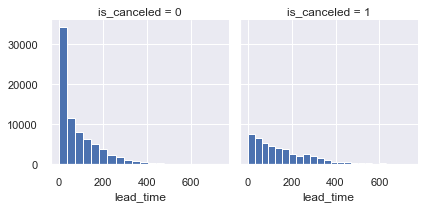

In [48]:
sns.FacetGrid(df, col='is_canceled').map(plt.hist, 'lead_time', bins=20)

Clientes frecuentres cancelan menos

In [49]:
df.arrival_date_week_number.unique()

array([27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26], dtype=int64)

In [50]:
df.arrival_date_day_of_month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int64)

#### Número de visitantes

In [51]:
df.adults.unique()

array([ 2,  1,  3,  4, 40, 26, 50, 27, 55,  0, 20,  6,  5, 10],
      dtype=int64)

In [52]:
df.adults.describe()

count    119390.000000
mean          1.856403
std           0.579261
min           0.000000
25%           2.000000
50%           2.000000
75%           2.000000
max          55.000000
Name: adults, dtype: float64

No puede haber reservaciones con cero adultos

In [53]:
df.children.unique()

array([ 0.,  1.,  2., 10.,  3., nan])

Debería ser un int

In [54]:
df.babies.unique()

array([ 0,  1,  2, 10,  9], dtype=int64)

Estos tres pueden ser una feature "Guests"

### Cancelaciones previas

In [55]:
df.previous_cancellations.unique()

array([ 0,  1,  2,  3, 26, 25, 14,  4, 24, 19,  5, 21,  6, 13, 11],
      dtype=int64)

In [56]:
df.previous_cancellations.value_counts()

0     112906
1       6051
2        116
3         65
24        48
11        35
4         31
26        26
25        25
6         22
19        19
5         19
14        14
13        12
21         1
Name: previous_cancellations, dtype: int64

<AxesSubplot:xlabel='is_canceled', ylabel='previous_cancellations'>

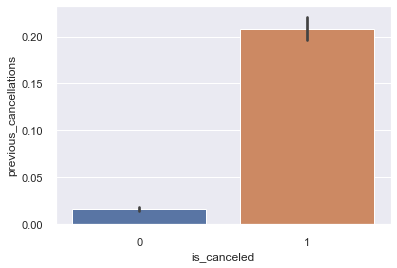

In [57]:
sns.barplot(data=df, x=df["is_canceled"], y=df["previous_cancellations"])

<AxesSubplot:xlabel='previous_cancellations', ylabel='arrival_date_month'>

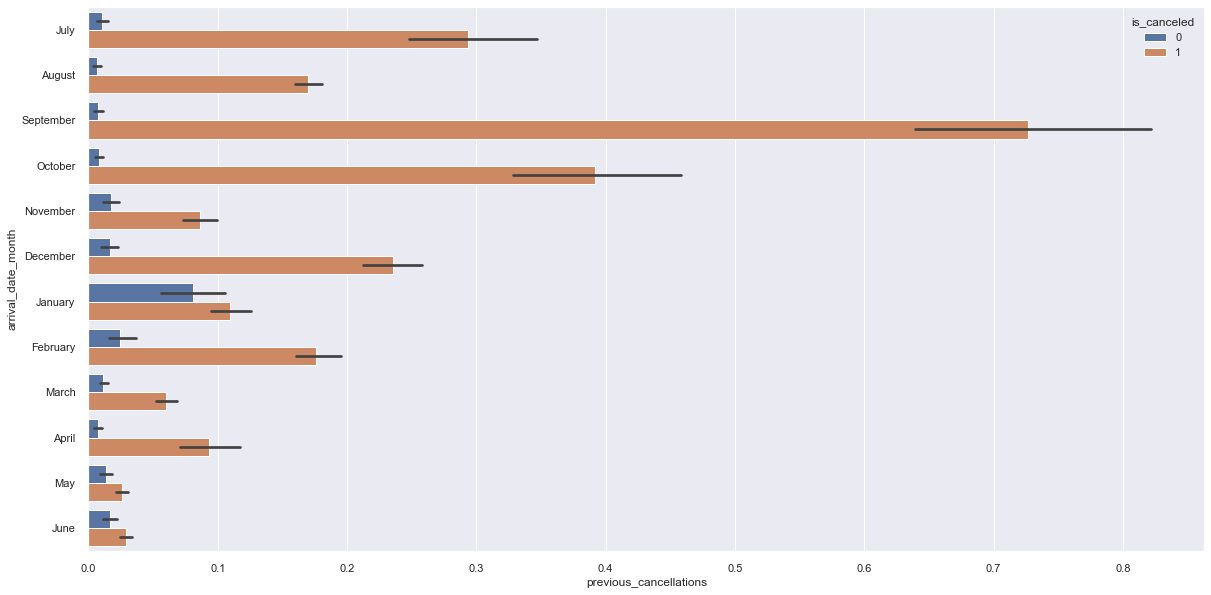

In [47]:
plt.figure(figsize=[20,10])
sns.barplot(data=df, hue=df["is_canceled"], x=df["previous_cancellations"], y=df["arrival_date_month"])

Septiembre y octubre son mesas con alta cancelación

In [60]:
df.previous_bookings_not_canceled.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 19, 26, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72], dtype=int64)

<AxesSubplot:xlabel='is_canceled', ylabel='previous_bookings_not_canceled'>

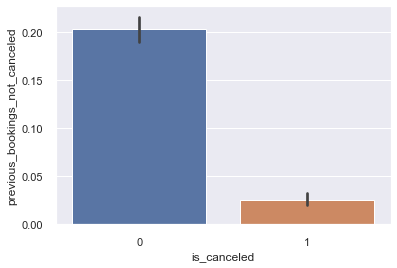

In [61]:
sns.barplot(data=df, x=df["is_canceled"], y=df["previous_bookings_not_canceled"])

In [62]:
(df["previous_bookings_not_canceled"] > 0).sum() / df.shape[0]

0.030320797386715805

In [63]:
df.booking_changes.unique()

array([ 3,  4,  0,  1,  2,  5, 17,  6,  8,  7, 10, 16,  9, 13, 12, 20, 14,
       15, 11, 21, 18], dtype=int64)

#### Número de noches

In [64]:
df.stays_in_weekend_nights.unique()

array([ 0,  1,  2,  4,  3,  6, 13,  8,  5,  7, 12,  9, 16, 18, 19, 10, 14],
      dtype=int64)

In [65]:
df.stays_in_week_nights.unique()

array([ 0,  1,  2,  3,  4,  5, 10, 11,  8,  6,  7, 15,  9, 12, 33, 20, 14,
       16, 21, 13, 30, 19, 24, 40, 22, 42, 50, 25, 17, 32, 26, 18, 34, 35,
       41], dtype=int64)

Estas dos podrían juntarse en una nueva columna 

#### Días en lista de espera

In [66]:
df.days_in_waiting_list.unique()

array([  0,  50,  47,  65, 122,  75, 101, 150, 125,  14,  60,  34, 100,
        22, 121,  61,  39,   5,   1,   8, 107,  43,  52,   2,  11, 142,
       116,  13,  44,  97,  83,   4, 113,  18,  20, 185,  93, 109,   6,
        37, 105, 154,  64,  99,  38,  48,  33,  77,  21,  80,  59,  40,
        58,  89,  53,  49,  69,  87,  91,  57, 111,  79,  98,  85,  63,
        15,   3,  41, 224,  31,  56, 187, 176,  71,  55,  96, 236, 259,
       207, 215, 160, 120,  30,  32,  27,  62,  24, 108, 147, 379,  70,
        35, 178, 330, 223, 174, 162, 391,  68, 193,  10,  76,  16,  28,
         9, 165,  17,  25,  46,   7,  84, 175, 183,  23, 117,  12,  54,
        26,  73,  45,  19,  42,  72,  81,  92,  74, 167,  36], dtype=int64)

<AxesSubplot:xlabel='is_canceled', ylabel='days_in_waiting_list'>

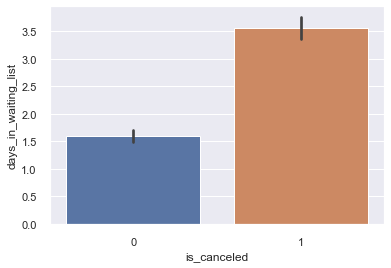

In [67]:
sns.barplot(data=df, y="days_in_waiting_list", x="is_canceled")

A más tiempo de espera más cancelaciones

<AxesSubplot:xlabel='is_canceled', ylabel='days_in_waiting_list'>

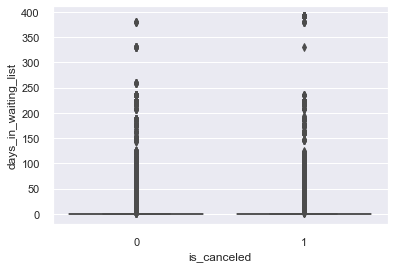

In [68]:
sns.boxplot(data=df, x="is_canceled", y="days_in_waiting_list")

Algunas reservas se hacen hasta un año antes.

##### Adr

In [69]:
df.adr.unique()

array([  0.  ,  75.  ,  98.  , ..., 266.75, 209.25, 157.71])

In [70]:
df.adr.describe()

count    119390.000000
mean        101.831122
std          50.535790
min          -6.380000
25%          69.290000
50%          94.575000
75%         126.000000
max        5400.000000
Name: adr, dtype: float64

Hay valores negativos, el minimo debería ser cero.

In [71]:
df.required_car_parking_spaces.unique()

array([0, 1, 2, 8, 3], dtype=int64)

In [72]:
df.total_of_special_requests.unique()

array([0, 1, 3, 2, 4, 5], dtype=int64)

#### Fecha de cambio de status

In [73]:
df.reservation_status_date.sample(3)

25678    2016-07-07
43985    2015-09-22
99249    2016-10-11
Name: reservation_status_date, dtype: object

Esto debería ser formato int no object

In [74]:
df[["reservation_status_date", "is_canceled"]].groupby("reservation_status_date", as_index=False).mean().sort_values(by="is_canceled", ascending=False)

,reservation_status_date,is_canceled
0,2014-10-17,1.0
91,2015-05-28,1.0
89,2015-05-26,1.0
88,2015-05-25,1.0
87,2015-05-23,1.0
...,...,...
237,2015-10-25,0.0
251,2015-11-08,0.0
272,2015-11-29,0.0
258,2015-11-15,0.0


### Buscamos valores faltantes

In [75]:
df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

Las variables Country, agent y company tienen nulos.

### Correlación

Medimos la correlación entre las variables

<AxesSubplot:>

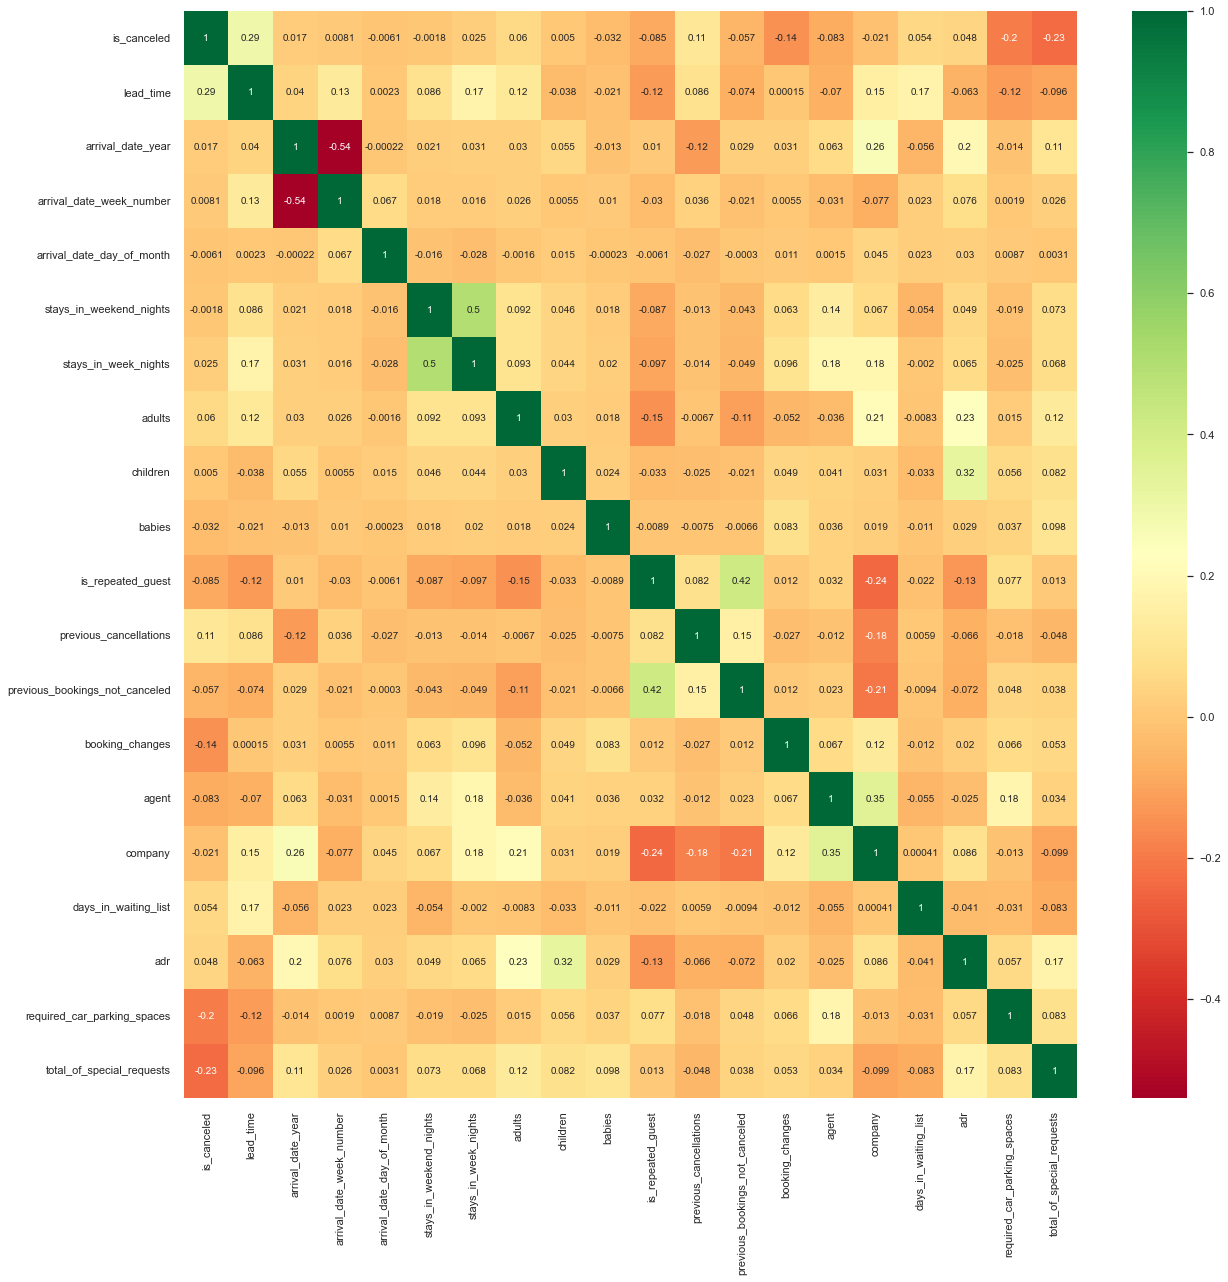

In [6]:
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(df.corr(), annot=True, cmap="RdYlGn")

<AxesSubplot:>

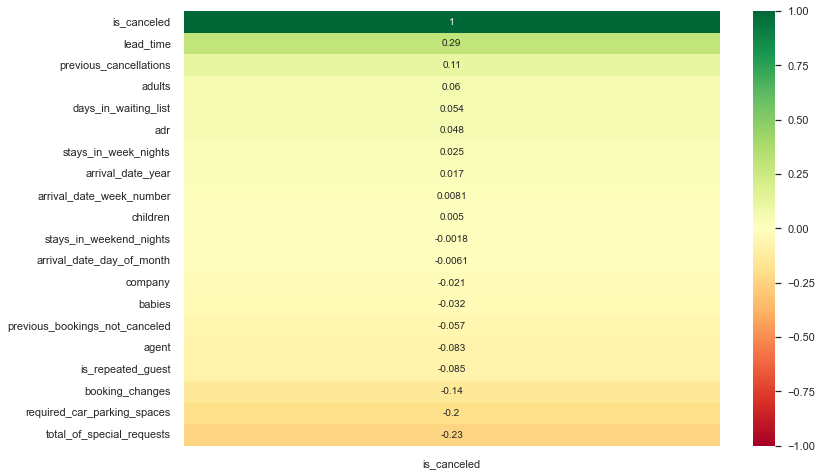

In [7]:
plt.figure(figsize=(12, 8))
df_correlation = df.corr()
target_correlation = df_correlation.loc[:, ['is_canceled']].sort_values('is_canceled', ascending=False)
sns.heatmap(target_correlation, annot=True, cmap="RdYlGn", vmin=-1, vmax=1)

### Conclusiones del EDA

- 42% de la información corresponde a City hotel.
- Este dataset cuenta con 119390 filas y 36 columnas.
- Hay dos tipos de hotel: Resort y City hotel, este último cuenta con más registros.
- El target se encuentra en la variable “is_canceled” que muestra con uno las reservas canceladas y con cero las que no.
- Hay visitantes de 177 países, los mayores visitantes vienen de Portugal, seguido por Reino Unido, Francia y España. De algunos países solo se hizo una reserva.
- Parece que aquellos que se han hospedado en el hotel con anterioridad tienden a cancelar menos que los nuevos visitantes.
- Septiembre y octubre son mesas con alta cancelación

## Manejo de valores faltantes, borrado de columnas y cambio de tipos

#### Se borran columnas según el EDA

Según el EDA y la correlación de las variables se decidieron eliminar las siguientes variables para evitar contaminar los resultados de los modelos, aligerarlos y simplificar.

In [3]:
df.drop(columns=["name", "email", "phone-number", "credit_card", "agent",
                "meal", "reservation_status", "company", "reserved_room_type", 
                 "total_of_special_requests", "booking_changes", "required_car_parking_spaces", 
                 "arrival_date_week_number"], inplace=True)

In [4]:
df.sample(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,assigned_room_type,deposit_type,days_in_waiting_list,customer_type,adr,reservation_status_date
94145,City Hotel,0,73,2016,July,29,1,2,3,1.0,0,FRA,Direct,Direct,0,0,0,E,No Deposit,0,Transient,173.7,2016-08-01
100662,City Hotel,0,36,2016,October,28,1,2,2,0.0,0,ITA,Online TA,TA/TO,0,0,0,A,No Deposit,0,Transient,109.0,2016-10-31
83687,City Hotel,0,59,2016,February,6,2,2,2,0.0,0,AUT,Groups,TA/TO,0,0,0,D,No Deposit,0,Transient-Party,62.0,2016-02-10
12676,Resort Hotel,1,23,2017,July,11,0,5,2,0.0,0,ESP,Direct,Direct,0,0,0,E,No Deposit,0,Transient,275.0,2017-06-20
80597,City Hotel,0,5,2016,February,3,0,1,1,0.0,0,PRT,Corporate,Corporate,1,0,4,A,No Deposit,0,Transient,66.0,2016-02-04


#### Manejo de variables categóricas

Para aprovechar mejor estas variables las convertiremos en binarias.

In [5]:
df["previous_cancellations"] = df["previous_cancellations"].apply(lambda x: 0 if x == 0 else 1)
df["previous_cancellations"].value_counts()

0    112906
1      6484
Name: previous_cancellations, dtype: int64

In [6]:
df["previous_bookings_not_canceled"] = df["previous_bookings_not_canceled"].apply(lambda x: 0 if x == 0 else 1)
df["previous_bookings_not_canceled"].value_counts()

0    115770
1      3620
Name: previous_bookings_not_canceled, dtype: int64

#### Manejo de variables numéricas

#### Reservation_status_date como tipo Date

In [7]:
df["reservation_status_date"] = pd.to_datetime(df["reservation_status_date"], format= "%Y/%m/%d")

In [8]:
df["reservation_status_date"].dt.month.value_counts()

7     12106
8     11249
10    11143
1     10681
5     10304
3     10230
4      9999
2      9498
9      9403
6      9278
11     8099
12     7400
Name: reservation_status_date, dtype: int64

#### Creamos una columna de estaciones

In [9]:
df["reservation_status_seasone"] = (df["reservation_status_date"].dt.month - 1) // 3

In [10]:
df.drop(columns="reservation_status_date", inplace=True)

#### Manejo de outliers

El valor minimo del ADR debe ser cero

In [11]:
df.drop(df[df["adr"] < 0].index, inplace=True)

In [12]:
df["adr"].describe()

count    119389.000000
mean        101.832028
std          50.535032
min           0.000000
25%          69.290000
50%          94.590000
75%         126.000000
max        5400.000000
Name: adr, dtype: float64

El valor minimo de adultos debe ser 1

In [13]:
df.drop(df[df["adults"] == 0].index, inplace=True)

In [14]:
df["adults"].describe()

count    118986.000000
mean          1.862690
std           0.570062
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max          55.000000
Name: adults, dtype: float64

In [15]:
df["adults"] = df["adults"].astype(int)

#### Creación de variables

Creamos la variable "guests" usando los valores de adults, children y babies,

In [16]:
df["guests"] = df["adults"] + df["children"] + df["babies"]

Creamos la variable "total nights" usando los valores de weekend y week nights

In [17]:
df["total_nights"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]

Nos quedamos solo con "total nights" para evitar redundancia

In [18]:
df.drop(columns = ["stays_in_weekend_nights", "stays_in_week_nights"], inplace=True)

In [19]:
df.sample(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,adults,children,babies,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,assigned_room_type,deposit_type,days_in_waiting_list,customer_type,adr,reservation_status_seasone,guests,total_nights
79187,City Hotel,0,34,2015,October,19,2,0.0,0,ESP,Offline TA/TO,TA/TO,0,0,0,D,No Deposit,0,Transient,105.12,3,2.0,4
107205,City Hotel,0,18,2017,March,6,3,0.0,0,CHE,Online TA,TA/TO,0,0,0,D,No Deposit,0,Transient,158.00,0,3.0,3
23613,Resort Hotel,0,12,2016,April,27,2,0.0,0,PRT,Groups,Direct,0,0,0,A,No Deposit,0,Transient-Party,85.33,1,2.0,3
66633,City Hotel,1,100,2017,April,22,2,0.0,0,PRT,Offline TA/TO,TA/TO,0,0,0,A,Non Refund,0,Transient,105.00,0,2.0,4
87019,City Hotel,0,86,2016,April,9,2,0.0,0,NLD,Offline TA/TO,TA/TO,0,0,0,B,No Deposit,0,Transient-Party,80.75,1,2.0,4


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118986 entries, 0 to 119389
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118986 non-null  object 
 1   is_canceled                     118986 non-null  int64  
 2   lead_time                       118986 non-null  int64  
 3   arrival_date_year               118986 non-null  int64  
 4   arrival_date_month              118986 non-null  object 
 5   arrival_date_day_of_month       118986 non-null  int64  
 6   adults                          118986 non-null  int32  
 7   children                        118982 non-null  float64
 8   babies                          118986 non-null  int64  
 9   country                         118508 non-null  object 
 10  market_segment                  118986 non-null  object 
 11  distribution_channel            118986 non-null  object 
 12  is_repeated_gues

Los nulos que quedan, la estandarización, el encoding y demás procesos se harán en el pipeline.

## Creación del pipeline

Agrupamos las columnas con valores categóricos.

In [21]:
categorical = [cname for cname in df.columns if df[cname].nunique() and  
                        df[cname].dtype == "object"]

print(categorical)
print("-"*90)
print(len(categorical))

['hotel', 'arrival_date_month', 'country', 'market_segment', 'distribution_channel', 'assigned_room_type', 'deposit_type', 'customer_type']
------------------------------------------------------------------------------------------
8


Agrupamos las columnas con valores númericos.

In [22]:
numerical = [cname for cname in df.columns if df[cname].dtype in 
                  ['int64', 'float64']]

numerical.remove("is_canceled")
print(numerical)
print("-"*90)
print(len(numerical))

['lead_time', 'arrival_date_year', 'arrival_date_day_of_month', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'days_in_waiting_list', 'adr', 'reservation_status_seasone', 'guests', 'total_nights']
------------------------------------------------------------------------------------------
13


Activamos el truncateSVD para hacer reducción de dimensionalidad.

In [23]:
tsvd = TruncatedSVD()

Creamos un transformer para las variables numéricas que agregue valores en los nulos, estandarice y reduzca dimensionalidad

In [24]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ("tsvd", tsvd)
])

Creamos otro para las variables categóricas que agregue valores en los nulos, haga OHE y reduzca dimensionalidad

In [25]:
categorical_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy= "most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown= "ignore")),
    ("tsvd", tsvd)
    
])

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical),
        ("cat", categorical_transformer, categorical),
        
        
         ], remainder = "passthrough")

In [27]:
y = df["is_canceled"]
X = df.drop(["is_canceled"], axis=1)

#### División del dataset

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.3, random_state=42, stratify=y)

## Despliegue de modelos

In [110]:
tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')

In [111]:
tree_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                ("model", tree)
                                ])

##### Buscamos los mejores hiperparmetros para regularizar el modelo

In [150]:
tree_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'model', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__tsvd', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__num__tsvd__algorithm', 'preprocessor__num__tsvd__n_components', 'preprocessor__num__tsvd__n_iter', 'preprocessor__num__tsv

Hacemos un random search

In [115]:
param_dist =  {
"preprocessor__num__tsvd__n_components": randint(5, 13),
"preprocessor__cat__tsvd__n_components": randint(5, 8),    
"model__min_samples_leaf": randint(10, 100),
'model__min_samples_split' : randint(2, 100),
'model__ccp_alpha': list(np.arange(0.0, 1., step=0.05))
}

In [148]:
rs = RandomizedSearchCV(estimator = tree_pipeline, 
                   n_iter=100,
                   param_distributions = param_dist,
                   n_jobs=-1, scoring = ["f1"], 
                   refit = "f1", 
                   cv=5, 
                   random_state=42,
                   verbose= 1)

In [149]:
%%time
rs.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 4min 58s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler()),
                                                                                               ('tsvd',
                                                                                                TruncatedSVD())]),
                                                                             

In [127]:
rs.best_params_

{'model__ccp_alpha': 0.0,
 'model__min_samples_leaf': 18,
 'model__min_samples_split': 44,
 'preprocessor__cat__tsvd__n_components': 6,
 'preprocessor__num__tsvd__n_components': 12}

In [128]:
rs.best_score_

0.7616077335487703

In [132]:
search_space_tree = {
'preprocessor__cat__tsvd__n_components': [5, 6],
'preprocessor__num__tsvd__n_components': [11, 12],
'model__max_depth': [10, 17, 20],
'model__min_samples_split': [42, 44],
'model__min_samples_leaf': [17, 18],
}

In [138]:
gs = GridSearchCV(estimator = tree_pipeline,
                     param_grid = search_space_tree,
                     scoring = ["f1"],
                     n_jobs=-1,
                     refit = "f1",
                     cv= 5,
                     verbose = 5)

In [139]:
%%time
gs.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Wall time: 2min 58s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('tsvd',
                                                                                          TruncatedSVD())]),
                                                                         ['lead_time',
                                                  

In [140]:
score = gs.best_score_
score

0.7619156331548821

In [141]:
bp = gs.best_params_
bp

{'model__max_depth': 20,
 'model__min_samples_leaf': 18,
 'model__min_samples_split': 42,
 'preprocessor__cat__tsvd__n_components': 6,
 'preprocessor__num__tsvd__n_components': 12}

In [142]:
pred_train = gs.predict(X_train)
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90     52410
           1       0.81      0.86      0.83     30880

    accuracy                           0.87     83290
   macro avg       0.86      0.87      0.86     83290
weighted avg       0.87      0.87      0.87     83290



In [143]:
pred_test = gs.predict(X_test)
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86     22461
           1       0.75      0.79      0.77     13235

    accuracy                           0.83     35696
   macro avg       0.81      0.82      0.81     35696
weighted avg       0.83      0.83      0.83     35696



In [144]:
pd.DataFrame(gs.cv_results_).sort_values(by="rank_test_f1")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__min_samples_leaf,param_model__min_samples_split,param_preprocessor__cat__tsvd__n_components,param_preprocessor__num__tsvd__n_components,params,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
43,5.909593,0.352149,0.152775,0.023438,20,18,42,6,12,"{'model__max_depth': 20, 'model__min_samples_l...",0.764428,0.762749,0.766819,0.755563,0.760019,0.761916,0.003873,1
39,5.752533,0.367464,0.137742,0.032969,20,17,44,6,12,"{'model__max_depth': 20, 'model__min_samples_l...",0.766283,0.763309,0.764757,0.755963,0.759150,0.761892,0.003799,2
47,4.120231,0.743095,0.074698,0.030800,20,18,44,6,12,"{'model__max_depth': 20, 'model__min_samples_l...",0.763757,0.764424,0.767201,0.754657,0.757861,0.761580,0.004608,3
35,5.727160,0.528002,0.132678,0.021309,20,17,42,6,12,"{'model__max_depth': 20, 'model__min_samples_l...",0.765735,0.762226,0.765700,0.756449,0.756529,0.761328,0.004152,4
46,5.756054,0.231365,0.133034,0.008300,20,18,44,6,11,"{'model__max_depth': 20, 'model__min_samples_l...",0.762425,0.766105,0.763892,0.750373,0.755390,0.759637,0.005858,5
41,5.663632,0.329802,0.158780,0.025666,20,18,42,5,12,"{'model__max_depth': 20, 'model__min_samples_l...",0.762486,0.763880,0.765496,0.754287,0.750889,0.759408,0.005750,6
37,5.593201,0.358663,0.135199,0.011575,20,17,44,5,12,"{'model__max_depth': 20, 'model__min_samples_l...",0.764592,0.763674,0.764103,0.754797,0.749691,0.759371,0.006046,7
42,5.671552,0.482549,0.134612,0.015834,20,18,42,6,11,"{'model__max_depth': 20, 'model__min_samples_l...",0.762150,0.766201,0.762195,0.753074,0.753226,0.759369,0.005287,8
38,5.326279,0.401823,0.145958,0.014537,20,17,44,6,11,"{'model__max_depth': 20, 'model__min_samples_l...",0.761957,0.766412,0.761332,0.749922,0.757015,0.759327,0.005567,9
45,5.545277,0.403864,0.136949,0.035746,20,18,44,5,12,"{'model__max_depth': 20, 'model__min_samples_l...",0.762021,0.763899,0.765270,0.753521,0.751085,0.759159,0.005744,10


Entrenamos nuevamente el modelo usando los nuevos hiperparametros

In [105]:
final_tree_cv = cross_val_score(gs, X_train, y_train, cv=5, scoring="f1")
final_tree_cv

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Fitting 3 folds for each of 48 candidates, totalling 144 fits


array([0.80378292, 0.80038238, 0.80181624, 0.79704733, 0.79958445])

<AxesSubplot:>

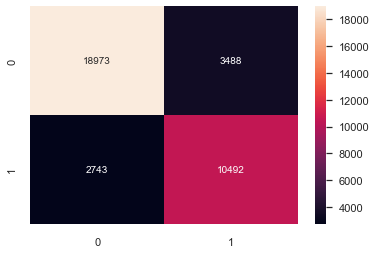

In [145]:
cm = confusion_matrix(y_test, pred_test)
sns.heatmap(cm, annot=True, fmt="g")

AUC for our classifier is: 0.9032494101726963


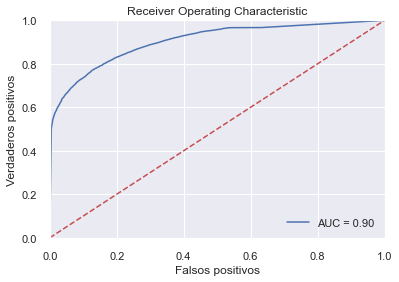

In [146]:
class_probabilities = gs.predict_proba(X_test)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# AUC
print(f"AUC for our classifier is: {roc_auc}")

# Gráfica de la Curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Verdaderos positivos')
plt.xlabel('Falsos positivos')
plt.show()

### Regresión logística

In [177]:
regression = LogisticRegression(random_state=0, class_weight='balanced')

In [178]:
regression_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                ("regression", regression) ])

In [101]:
regression_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'regression', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__tsvd', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__num__tsvd__algorithm', 'preprocessor__num__tsvd__n_components', 'preprocessor__num__tsvd__n_iter', 'preprocessor__num

Hacemos un random search

In [183]:
parameters ={
        'preprocessor__num__tsvd__n_components': randint(5, 13),
        'preprocessor__cat__tsvd__n_components': randint(5, 8),
        'regression__multi_class':["auto", "ovr"],
        'regression__fit_intercept': [True,False],
        'regression__intercept_scaling': randint(1, 10),
        'regression__max_iter': randint(100, 500)
    }

In [184]:
randomregression = RandomizedSearchCV(estimator = regression_pipeline, 
                   n_iter=50,
                   param_distributions = parameters,
                   n_jobs=-1, scoring = ["f1"], 
                   refit = "f1", 
                   cv=3, 
                   random_state=42,
                   verbose= 1)

In [185]:
%%time
randomregression.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Wall time: 1min 6s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler()),
                                                                                               ('tsvd',
                                                                                                TruncatedSVD())]),
                                                                             

In [186]:
randomregression.best_params_

{'preprocessor__cat__tsvd__n_components': 7,
 'preprocessor__num__tsvd__n_components': 12,
 'regression__fit_intercept': False,
 'regression__intercept_scaling': 7,
 'regression__max_iter': 351,
 'regression__multi_class': 'auto'}

In [187]:
randomregression.best_score_

0.6929315835247353

In [191]:
search_logistic_regression = {
 'preprocessor__cat__tsvd__n_components': [7, 6],
 'preprocessor__num__tsvd__n_components': [11, 12],
 'regression__fit_intercept': [False],
 'regression__intercept_scaling': [7, 5, 6],
 'regression__max_iter': [351, 350],
 'regression__multi_class': ['auto']
}

In [192]:
logisticgs = GridSearchCV(estimator = regression_pipeline,
                     param_grid = search_logistic_regression,
                     scoring = ["f1"],
                     n_jobs=-1,
                     refit = "f1",
                     cv= 4,
                     verbose = 4)

In [193]:
%%time
logisticgs.fit(X_train, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
Wall time: 51.6 s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('tsvd',
                                                                                          TruncatedSVD())]),
                                                                         ['lead_time',
                                                  

In [194]:
logisticgs.best_params_

{'preprocessor__cat__tsvd__n_components': 7,
 'preprocessor__num__tsvd__n_components': 12,
 'regression__fit_intercept': False,
 'regression__intercept_scaling': 5,
 'regression__max_iter': 350,
 'regression__multi_class': 'auto'}

In [195]:
logisticgs.best_score_

0.6928219124999713

In [196]:
logisticgs_test = logisticgs.predict(X_test)
print(classification_report(y_test, logisticgs_test))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     22461
           1       0.69      0.70      0.70     13235

    accuracy                           0.77     35696
   macro avg       0.76      0.76      0.76     35696
weighted avg       0.77      0.77      0.77     35696



In [197]:
cross_val_score(logisticgs, X_train, y_train, cv=5, scoring="f1")

Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits


array([0.69400681, 0.69014763, 0.69361397, 0.69150212, 0.69391983])

<AxesSubplot:>

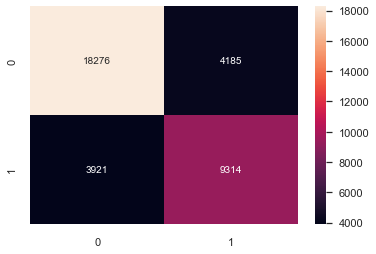

In [198]:
cm = confusion_matrix(y_test, logisticgs_test)
sns.heatmap(cm, annot=True, fmt="g")

AUC for our classifier is: 0.8511245004500685


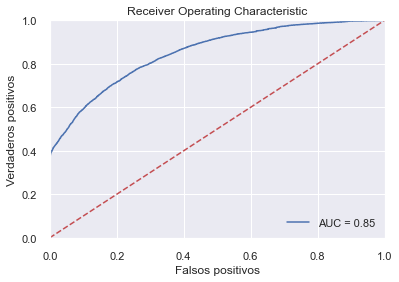

In [199]:
class_probabilities = logisticgs.predict_proba(X_test)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# AUC
print(f"AUC for our classifier is: {roc_auc}")

# Gráfica de la Curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Verdaderos positivos')
plt.xlabel('Falsos positivos')
plt.show()

### Random forest

In [159]:
randomf = RandomForestClassifier(random_state=42, class_weight='balanced')

In [160]:
randomf_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                ("randomf", randomf) ])

In [161]:
randomf_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'randomf', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__tsvd', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__num__tsvd__algorithm', 'preprocessor__num__tsvd__n_components', 'preprocessor__num__tsvd__n_iter', 'preprocessor__num__t

Hacemos un random search

In [162]:
param_dist = {
"preprocessor__num__tsvd__n_components": randint(5, 13),
"preprocessor__cat__tsvd__n_components": randint(5, 8),
'randomf__n_estimators': randint(100, 2000),
'randomf__max_depth': randint(10, 100), 
'randomf__max_leaf_nodes': randint(3, 100),
'randomf__max_samples': randint(1, 100),
'randomf__min_samples_split': randint(4, 100)
              }

In [163]:
rsrandomf = RandomizedSearchCV(estimator = randomf_pipeline, 
                   n_iter=100,
                   param_distributions = param_dist,
                   n_jobs=-1, scoring = ["f1"], 
                   refit = "f1", 
                   cv=4, 
                   random_state=42,
                   verbose= 1)

In [164]:
%%time
rsrandomf.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
Wall time: 17min 23s


RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler()),
                                                                                               ('tsvd',
                                                                                                TruncatedSVD())]),
                                                                             

In [165]:
rsrandomf.best_params_

{'preprocessor__cat__tsvd__n_components': 5,
 'preprocessor__num__tsvd__n_components': 12,
 'randomf__max_depth': 26,
 'randomf__max_leaf_nodes': 46,
 'randomf__max_samples': 92,
 'randomf__min_samples_split': 33,
 'randomf__n_estimators': 576}

In [166]:
rsrandomf.best_score_

0.6644808092260801

In [168]:
search_random_forest = {
    'preprocessor__cat__tsvd__n_components': [5, 6],
    'preprocessor__num__tsvd__n_components': [12, 11],          
    'randomf__max_depth': [23, 25, 26], 
    'randomf__max_samples': [93, 92],
    'randomf__n_estimators': [576]
              }

In [169]:
randomgs = GridSearchCV(estimator = randomf_pipeline,
                     param_grid = search_random_forest,
                     scoring = ["f1"],
                     n_jobs=-1,
                     refit = "f1",
                     cv= 5,
                     verbose = 4)

In [170]:
%%time
randomgs.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Wall time: 3min 24s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('tsvd',
                                                                                          TruncatedSVD())]),
                                                                         ['lead_time',
                                                  

In [171]:
randomgs.best_params_

{'preprocessor__cat__tsvd__n_components': 5,
 'preprocessor__num__tsvd__n_components': 12,
 'randomf__max_depth': 25,
 'randomf__max_samples': 92,
 'randomf__n_estimators': 576}

In [172]:
randomgs.best_score_

0.5972750870383681

In [173]:
randomgs_test = randomgs.predict(X_test)
print(classification_report(y_test, randomgs_test))

              precision    recall  f1-score   support

           0       0.75      0.98      0.85     22461
           1       0.94      0.43      0.59     13235

    accuracy                           0.78     35696
   macro avg       0.84      0.71      0.72     35696
weighted avg       0.82      0.78      0.76     35696



In [174]:
cross_val_score(randomgs, X_train, y_train, cv=5, scoring="f1")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


array([0.59878654, 0.59763248, 0.60024168, 0.58686229, 0.59151488])

<AxesSubplot:>

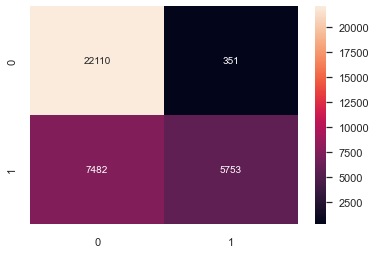

In [175]:
cm = confusion_matrix(y_test, randomgs_test)
sns.heatmap(cm, annot=True, fmt="g")

AUC for our classifier is: 0.8616904872445909


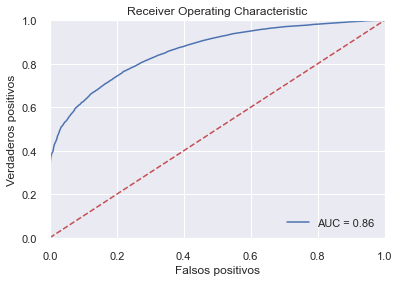

In [176]:
class_probabilities = randomgs.predict_proba(X_test)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# AUC
print(f"AUC for our classifier is: {roc_auc}")

# Gráfica de la Curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Verdaderos positivos')
plt.xlabel('Falsos positivos')
plt.show()

### LightGBM

In [200]:
light = LGBMClassifier(random_state=0, class_weight='balanced')

In [201]:
light_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                ("light", light) ])

In [202]:
lgbm_parameters = {
    'preprocessor__num__tsvd__n_components': randint(5, 12),
    'preprocessor__cat__tsvd__n_components': randint(5, 8),
    'light__n_estimators': randint(2000, 5000),
    'light__max_depth': randint(1, 20),
    'light__num_leaves': randint(10, 50),
}

In [203]:
random_light = RandomizedSearchCV(estimator = light_pipeline, 
                   n_iter=100,
                   param_distributions = lgbm_parameters,
                   n_jobs=-1, scoring = ["f1"], 
                   refit = "f1", 
                   cv=4, 
                   random_state=42,
                   verbose= 1)

In [204]:
%%time
random_light.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
Wall time: 1h 1min 58s


RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler()),
                                                                                               ('tsvd',
                                                                                                TruncatedSVD())]),
                                                                             

In [205]:
random_light.best_params_

{'light__max_depth': 15,
 'light__n_estimators': 3115,
 'light__num_leaves': 43,
 'preprocessor__cat__tsvd__n_components': 6,
 'preprocessor__num__tsvd__n_components': 11}

In [206]:
random_light.best_score_

0.8377610877611602

In [209]:
search_light = {
'light__max_depth': [15, 16, 17],
 'light__n_estimators': [3115],
 'light__num_leaves': [43, 44, 45],
 'preprocessor__cat__tsvd__n_components': [6],
 'preprocessor__num__tsvd__n_components': [11]
}

In [210]:
lightgs = GridSearchCV(estimator = light_pipeline,
                     param_grid = search_light,
                     scoring = ["f1"],
                     n_jobs=-1,
                     refit = "f1",
                     cv= 5,
                     verbose = 4)

In [211]:
%%time
lightgs.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Wall time: 7min 33s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('tsvd',
                                                                                          TruncatedSVD())]),
                                                                         ['lead_time',
                                                  

In [212]:
lightgs.best_params_

{'light__max_depth': 16,
 'light__n_estimators': 3115,
 'light__num_leaves': 45,
 'preprocessor__cat__tsvd__n_components': 6,
 'preprocessor__num__tsvd__n_components': 11}

In [213]:
lightgs.best_score_

0.8406825152421916

In [214]:
lightgs_test = lightgs.predict(X_test)
print(classification_report(y_test, lightgs_test))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     22461
           1       0.88      0.82      0.85     13235

    accuracy                           0.89     35696
   macro avg       0.89      0.88      0.88     35696
weighted avg       0.89      0.89      0.89     35696



In [215]:
cross_val_score(lightgs, X_train, y_train, cv=5, scoring="f1")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


array([0.84282116, 0.84072666, 0.83988882, 0.8364557 , 0.8356315 ])

<AxesSubplot:>

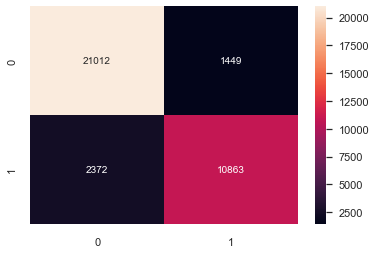

In [216]:
cm = confusion_matrix(y_test, lightgs_test)
sns.heatmap(cm, annot=True, fmt="g")

AUC for our classifier is: 0.9515071138628284


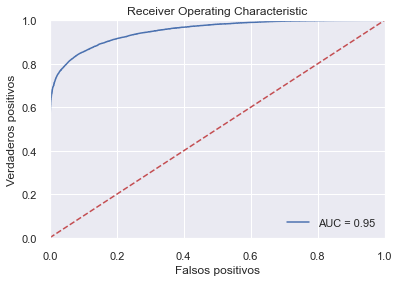

In [217]:
class_probabilities = lightgs.predict_proba(X_test)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# AUC
print(f"AUC for our classifier is: {roc_auc}")

# Gráfica de la Curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Verdaderos positivos')
plt.xlabel('Falsos positivos')
plt.show()